In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-04-12 17:19:45.284851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 17:19:45.284964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 17:19:45.427414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/kaggle/input/flowers-recognition/flowers"

# Train ve test dizinlerini oluştur
train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.90

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")

Train-test split completed successfully.


In [4]:
# Kinds of flowers
kinds = np.array(os.listdir('/kaggle/input/flowers-recognition/flowers'))
print(f"Flower kinds in dataset: {kinds}")

Flower kinds in this dataset: ['dandelion' 'daisy' 'sunflower' 'tulip' 'rose']


In [5]:
# Paths of directories
path = '/kaggle/input/flowers-recognition/flowers'
kind_path = [path + "/" + flower for flower in kinds]
kind_path

['/kaggle/input/flowers-recognition/flowers/dandelion',
 '/kaggle/input/flowers-recognition/flowers/daisy',
 '/kaggle/input/flowers-recognition/flowers/sunflower',
 '/kaggle/input/flowers-recognition/flowers/tulip',
 '/kaggle/input/flowers-recognition/flowers/rose']

In [6]:
# Numbers of flowers for each kinds
for i, kind in enumerate(kind_path):
    print(f"There are {len(os.listdir(kind))} flowers in {kinds[i]}")

There are 1052 flowers in dandelion
There are 764 flowers in daisy
There are 733 flowers in sunflower
There are 984 flowers in tulip
There are 784 flowers in rose


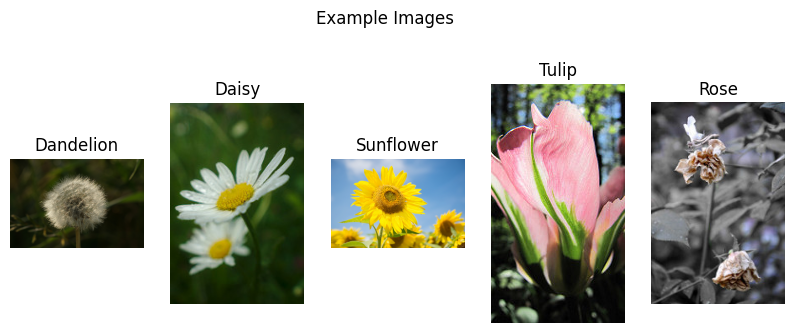

In [7]:
# Example images for each kinds
plt.figure(figsize=(10,4))
plt.suptitle("Example Images")
for i, kind in enumerate(kinds):
    ax = plt.subplot(1, 5, i+1)
    path = kind_path[i] + "/" + os.listdir(kind_path[i])[1]
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(kind.capitalize())
    plt.axis("off")

In [8]:
# All ids
id_df = []
for i in range(len(kinds)):
    id = [img.split(".")[0] for img in os.listdir(kind_path[i])]
    id_df = id_df + id
len(id_df)

4317

In [9]:
# All kinds
kind_df = []
for i, kind in enumerate(kinds):
    for x in range(len(os.listdir(kind_path[i]))):
        kind_df.append(kind)
len(kind_df)

4317

In [10]:
# Create a dataframe
df = pd.DataFrame(columns=["id", "kind"])
df["id"] = id_df
df["kind"] = kind_df
df.tail()

,id,kind
4312,7820626638_3e2d712303,rose
4313,5148639829_781eb7d346,rose
4314,5335946401_f49bfbe3f9_n,rose
4315,8063462557_e0a8bd6c64_n,rose
4316,2536282942_b5ca27577e,rose


In [11]:
# Check numbers
df["kind"].value_counts(normalize = True)

kind
dandelion    0.243688
tulip        0.227936
rose         0.181608
daisy        0.176975
sunflower    0.169794
Name: proportion, dtype: float64

In [12]:
filenames = []
for i in range(len(kinds)):
    file = [kind_path[i] + "/" + kind for kind in os.listdir(kind_path[i])]
    filenames = filenames + file
filenames[:5]

['/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg']

In [32]:
# Check a random flower
print(filenames[2317])
print(df.loc[2317])

/kaggle/input/flowers-recognition/flowers/sunflower/8174935013_b16626b49b.jpg
id      8174935013_b16626b49b
kind                sunflower
Name: 2317, dtype: object


In [13]:
boolean_kinds = [kind == kinds for kind in kind_df]
boolean_kinds[:5]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False])]

# **Train and Test Split**

In [14]:
X = filenames
y = boolean_kinds

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1,
                                                   stratify = y)
len(X_train), len(X_test), len(y_train), len(y_test)

(3885, 432, 3885, 432)

# **Image Preprocessing**

In [16]:
image = imread(filenames[1])
image.shape

(333, 500, 3)

In [33]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[38, 30, 11],
        [38, 30, 11],
        [38, 30, 11],
        ...,
        [30, 37,  6],
        [31, 36,  6],
        [31, 36,  4]],

       [[38, 30, 11],
        [38, 30, 11],
        [37, 29, 10],
        ...,
        [31, 38,  5],
        [31, 38,  5],
        [33, 38,  6]]], dtype=uint8)>

In [34]:
# Create a function for preprocessing images
def process_image(image_path, img_size=256):
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, 256])

  return image

In [35]:
process_image(X[17]), tf.constant(y[17])

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.04313726, 0.03137255, 0.01176471],
         [0.04339067, 0.03162597, 0.01201812],
         [0.04500248, 0.03323777, 0.01362993],
         ...,
         [0.03379289, 0.02987133, 0.01026348],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04583136, 0.03406665, 0.01445881],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03337821, 0.02945665, 0.0098488 ],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04410999, 0.03234528, 0.01273744],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03287378, 0.02895221, 0.00934436],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        ...,
 
        [[0.45161214, 0.35360354

# **Data Augmentation**

In [17]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    rescale = 1/255
)

In [18]:
batch_size = 32
img_height = 256
img_width = 256

In [19]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 3107 images belonging to 5 classes.
Found 775 images belonging to 5 classes.


In [20]:
image_shape = (256,256,3)

# **CNN Model**

In [21]:
# to select the weights for the epoch with the highest val_score

class GetBestModel(tf.keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [22]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [23]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,645 (9.04 MB)

 Trainable params: 2,366,597 (9.03 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [24]:
results = model.fit(training_data,epochs=5,
                    validation_data=validation_data,
                    callbacks = [early_stop, best_model])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/98 ━━━━━━━━━━━━━━━━━━━━ 51:43 32s/step - accuracy: 0.2500 - loss: 2.1669

I0000 00:00:1712942489.015579     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/98 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.1924 - loss: 1.8292 

W0000 00:00:1712942525.850638     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 592ms/step - accuracy: 0.1945 - loss: 1.7982 - val_accuracy: 0.2439 - val_loss: 1.7149
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 489ms/step - accuracy: 0.2169 - loss: 1.6122 - val_accuracy: 0.2439 - val_loss: 1.6920
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 484ms/step - accuracy: 0.1911 - loss: 1.6236 - val_accuracy: 0.2439 - val_loss: 1.6114
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 491ms/step - accuracy: 0.2413 - loss: 1.5949 - val_accuracy: 0.2077 - val_loss: 1.5990
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 484ms/step - accuracy: 0.2076 - loss: 1.6152 - val_accuracy: 0.2477 - val_loss: 1.5836


In [25]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.205021,1.677688,0.243871,1.714857
1,0.223688,1.614305,0.243871,1.691974
2,0.214998,1.610545,0.243871,1.611434
3,0.224010,1.607399,0.207742,1.598958
4,0.220148,1.606143,0.247742,1.583627


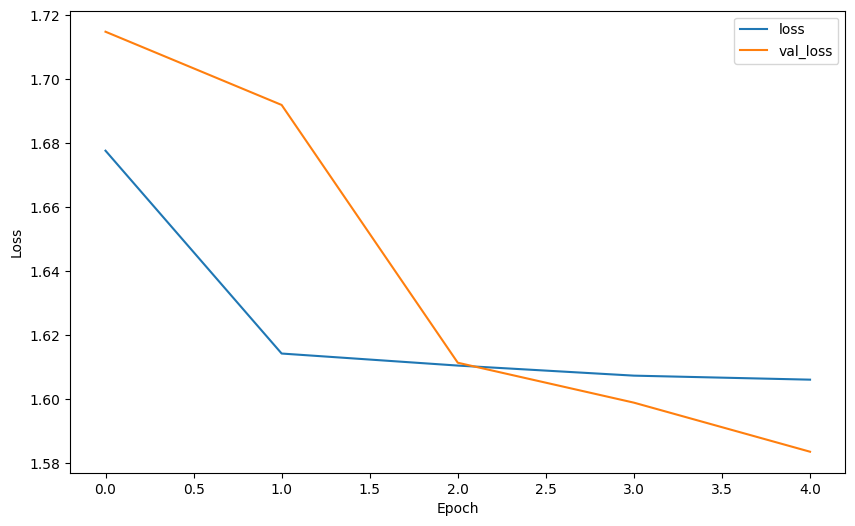

In [26]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

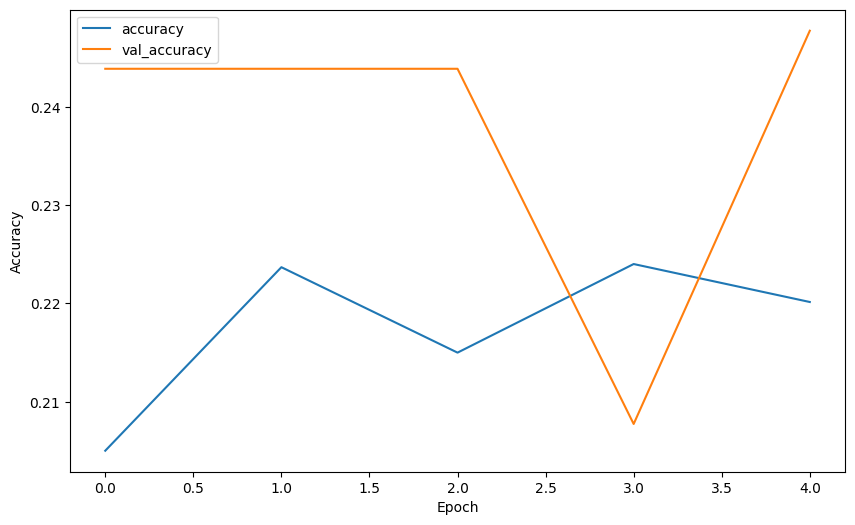

In [27]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [28]:
model.evaluate(training_data)
model.evaluate(validation_data)

98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - accuracy: 0.2828 - loss: 1.6196


W0000 00:00:1712942818.404397     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step - accuracy: 0.2796 - loss: 1.6131


[1.5851271152496338, 0.24258065223693848]

In [29]:
pred_probabilities = model.predict(validation_data)
pred_probabilities

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step


array([[0.17489754, 0.26005772, 0.17417121, 0.1624443 , 0.22842918],
       [0.17259355, 0.2580174 , 0.17670937, 0.15880342, 0.23387621],
       [0.17912586, 0.23855373, 0.18682237, 0.16675183, 0.22874627],
       ...,
       [0.1139389 , 0.6210531 , 0.04341307, 0.0221712 , 0.19942378],
       [0.12762001, 0.42707452, 0.11182259, 0.08389457, 0.24958836],
       [0.11629312, 0.5345876 , 0.08031701, 0.04208963, 0.22671269]],
      dtype=float32)

In [30]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [31]:
predictions = pred_probabilities > 0.5

In [ ]:
#print(classification_report(validation_data.classes,predictions))

# **Xception Model**

In [ ]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
xception_model.evaluate(training_data)
xception_model.evaluate(validation_data)

In [ ]:
pred_probabilities = xception_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
#print(classification_report(validation_data.classes,predictions))

preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
# Confusion matrix
cm = confusion_matrix(validation_data.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

# **MobilNetV2 Model**

In [ ]:
mobilenet_model = Sequential()
pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
mobilenet_model.evaluate(training_data)
mobilenet_model.evaluate(validation_data)

In [ ]:
pred_probabilities = mobilenet_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:10]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
validation_data.classes

In [ ]:
#print(classification_report(validation_data.classes,predictions))

preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
# Confusion matrix
cm = confusion_matrix(validation_data.classes, y_pred)
#plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

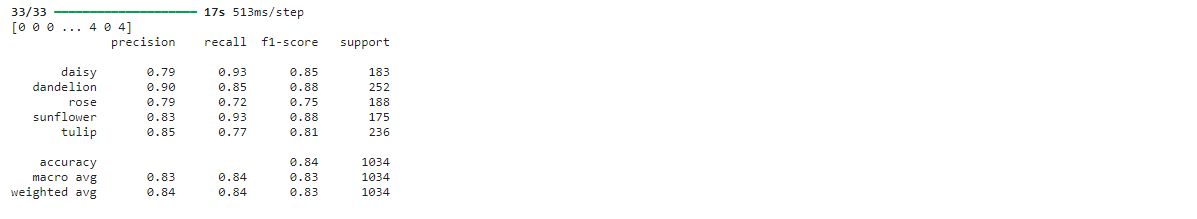